In [20]:
data_df['Embarked'].isnull().sum()

2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import copy, torch, os
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
data_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
print(train_df.columns.values)
data_NN = copy.copy(train_df)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


# Data Analysis

The test set contains 891 train data and 418 test data with total of 1309 data
- 843 is male and 466 is female
- 56 person is infant (<=5 yr old) while 22 person is under 20
- The oldest person on the ship is 80 yr old, survived 
- Has 1 sibling/Spouse

(array([13.,  5., 11.,  5., 51., 48., 56., 54., 30., 34., 28., 17., 23.,
        15.,  7.,  8.,  7.,  6.,  2.,  4.]),
 array([ 1.  ,  4.65,  8.3 , 11.95, 15.6 , 19.25, 22.9 , 26.55, 30.2 ,
        33.85, 37.5 , 41.15, 44.8 , 48.45, 52.1 , 55.75, 59.4 , 63.05,
        66.7 , 70.35, 74.  ]),
 <BarContainer object of 20 artists>)

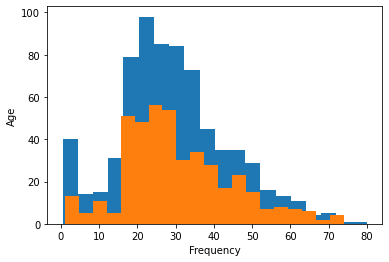

In [2]:
plt.hist(data_df['Age'][data_df['Survived']>-1],bins=20)
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.hist(data_df['Age'][data_df['Survived']==0],bins=20)

# Correlation check
The result show, you will likely to survive if
- You are Female (74% survival rate)
- You are from upper class (63% survival rate)
- Embarked From Cherbourg (56% survival rate)
- Ship with 1 sibling/spouse (53% survival rate)
- Ship with 3 child/parents (60% survival rate)

In [3]:
print(train_df[['Sex','Survived']].groupby('Sex',as_index=False).mean())
print(train_df[['Pclass','Survived']].groupby('Pclass',as_index=False).mean())
print(train_df[['Pclass','Survived']].groupby('Pclass',as_index=False).mean())
print(train_df[['Embarked','Survived']].groupby('Embarked',as_index=False).mean())
print(train_df[['SibSp','Survived']].groupby('SibSp',as_index=False).mean())
print(train_df[['Parch','Survived']].groupby('Parch',as_index=False).mean())
print(train_df[['Age','Survived']].groupby([pd.cut(train_df['Age'],list(range(0,80,10)))]).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
                Age  Survived
Age                          
(0, 10]    4.268281  0.593750
(10, 20]  17.317391  0.382609
(20, 30]  25.423913  0.365217
(30, 40]  35.051613  0.445161
(40, 50]  45.372093  0.383721
(50, 60]  54.892857  0.404762
(60, 70]  63.882353  0.235294


# Processing

In [9]:
data_df['Title'] = data_df['Name'].str.extract(r' ([A-Za-z]+)\.')
data_df = data_df.drop(columns=['Name','Ticket','Cabin','PassengerId'])
data_df['Age']  = data_df['Age'].fillna(0)
""""
title_list_count = (data_df.groupby(['Title'],as_index=False)).count().values[:,:2]
title_list_count[:,1] = title_list_count[:,1]<5
title_list_rare = title_list_count[:,0][title_list_count[:,1]==True].astype(str)
for x in range(data_df.shape[0]):
    if data_df['Title'].loc[x] in title_list_rare:
        data_df['Title'].loc[x] = 'etc'
"""

'"\ntitle_list_count = (data_df.groupby([\'Title\'],as_index=False)).count().values[:,:2]\ntitle_list_count[:,1] = title_list_count[:,1]<5\ntitle_list_rare = title_list_count[:,0][title_list_count[:,1]==True].astype(str)\nfor x in range(data_df.shape[0]):\n    if data_df[\'Title\'].loc[x] in title_list_rare:\n        data_df[\'Title\'].loc[x] = \'etc\'\n'

In [5]:
data_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0.0,3,male,22.0,1,0,7.2500,S,Mr
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs
2,1.0,3,female,26.0,0,0,7.9250,S,Miss
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs
4,0.0,3,male,35.0,0,0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,0.0,0,0,8.0500,S,Mr
1305,NaN,1,female,39.0,0,0,108.9000,C,Dona
1306,NaN,3,male,38.5,0,0,7.2500,S,Mr
1307,NaN,3,male,0.0,0,0,8.0500,S,Mr


In [11]:
from sklearn import preprocessing
label_list = ['Sex','Title','Embarked']
le = []
for index, i in enumerate(label_list):
    le.append(preprocessing.LabelEncoder())
    le[index].fit(data_df[i])
    data_df[i] = le[index].transform(data_df[i])
train_data = data_df[data_df['Survived']>=0]
test_data = data_df[data_df['Survived'].isnull()]
X_train = train_data.drop(columns=['Survived'])
y_train = train_data['Survived']

X_test = test_data.drop(columns=['Survived'])
X_test['Fare'] = X_test['Fare'].fillna(0)

In [14]:
le[2].classes_

array(['C', 'Q', 'S', nan], dtype=object)

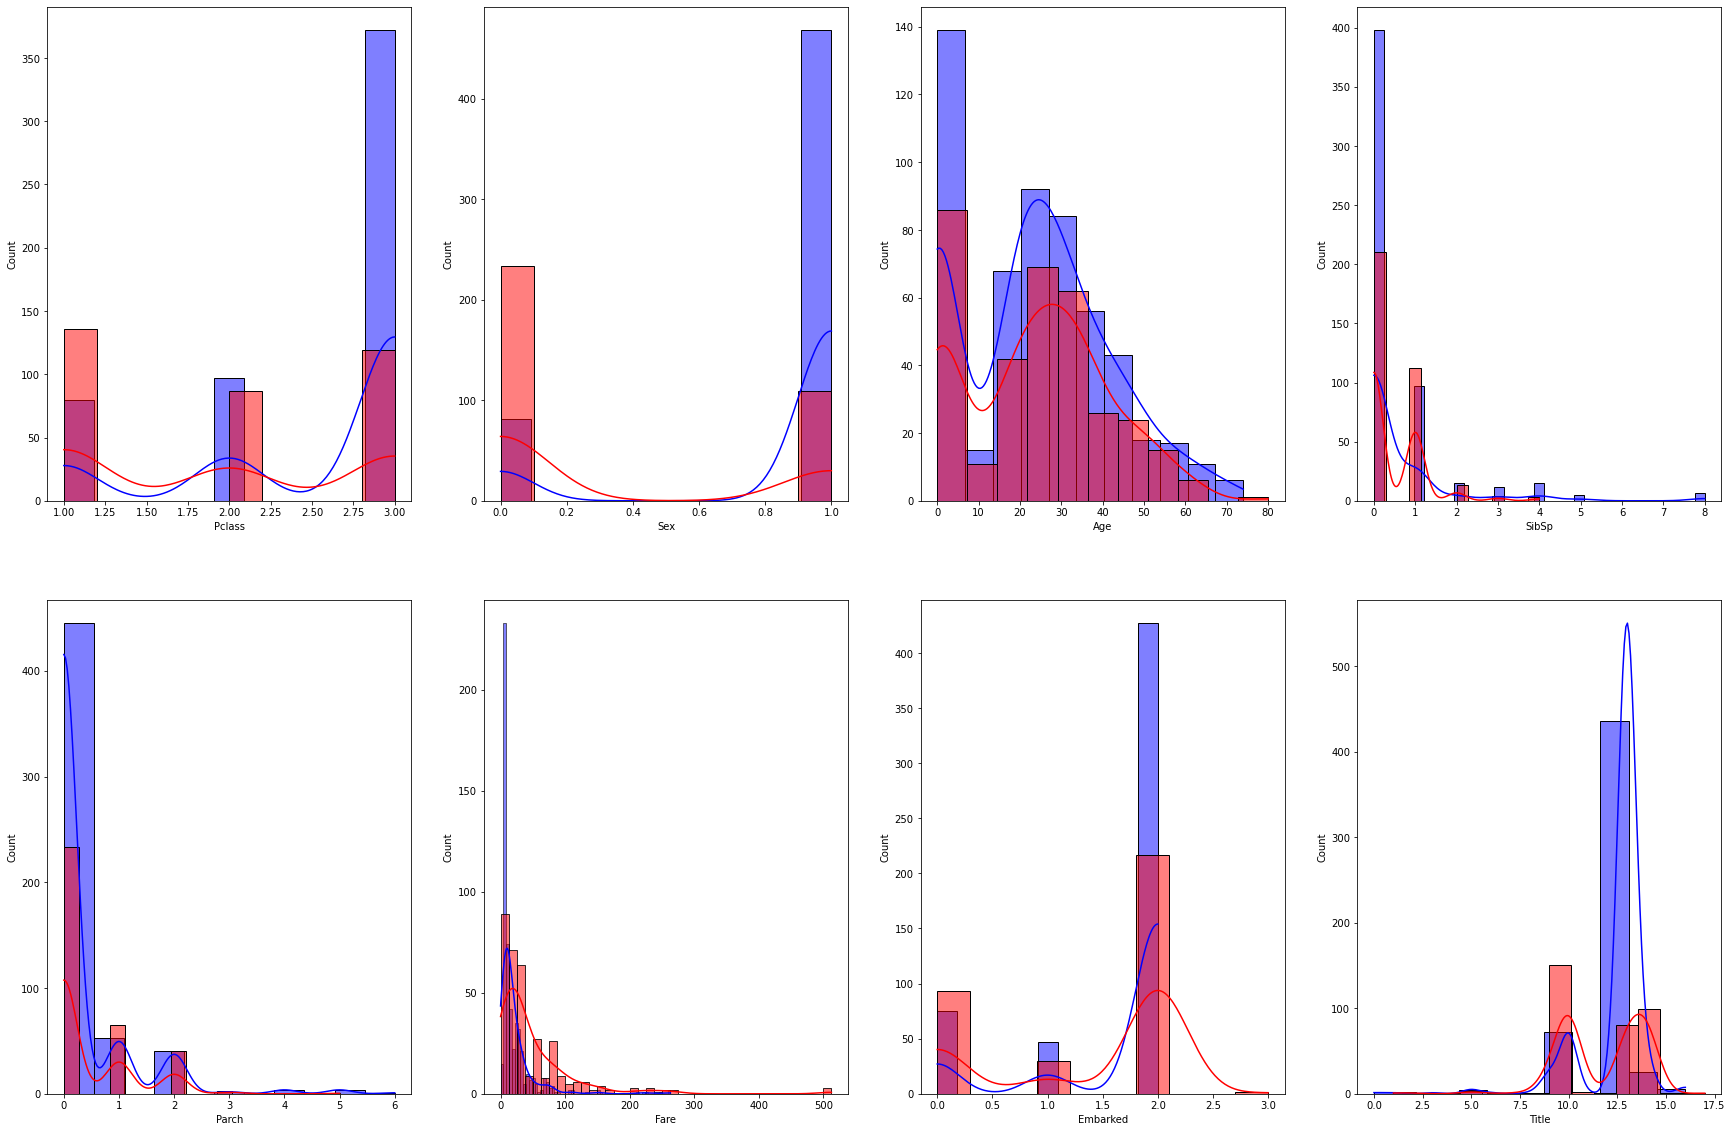

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
figs, axs = plt.subplots(2,4,figsize=(30,20))
for index, columns_name in enumerate(train_data.drop(columns='Survived').columns.values):
    sns.histplot(ax = axs[index//4, index%4] ,data=train_data[train_data['Survived']==0], x=columns_name, color="blue", kde=True)
    sns.histplot(ax = axs[index//4, index%4] ,data=train_data[train_data['Survived']==1], x=columns_name, color="red", kde=True)

<AxesSubplot:>

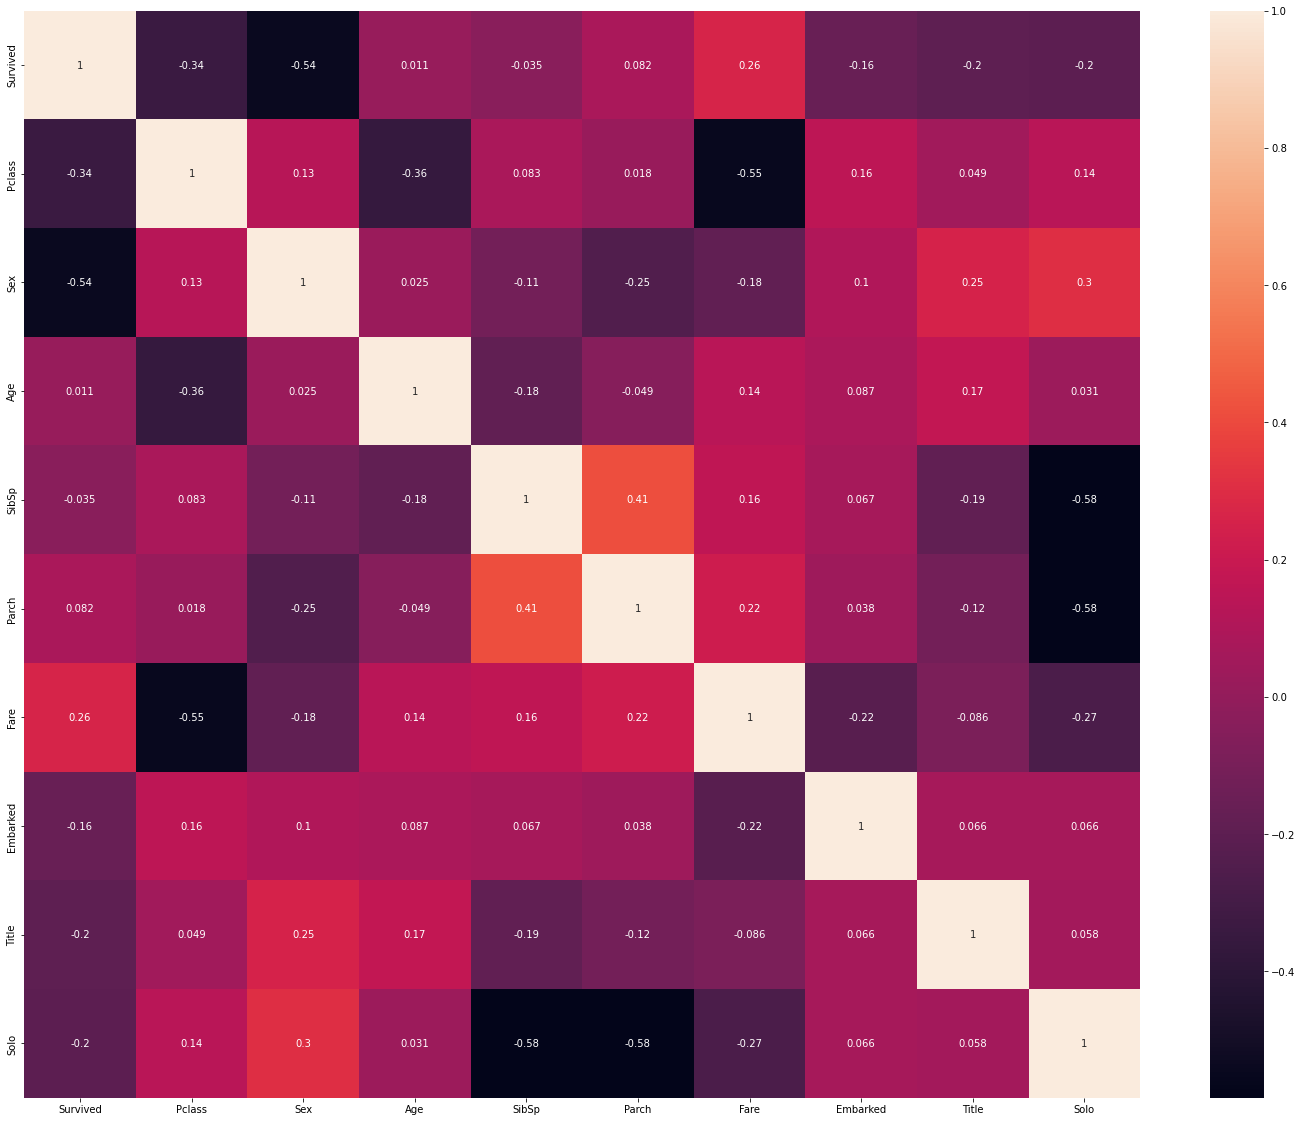

In [51]:
import seaborn as sns
fig, axs = plt.subplots(figsize=(25,20)) 
sns.heatmap(train_data.corr(),ax = axs,annot=True)


<AxesSubplot:>

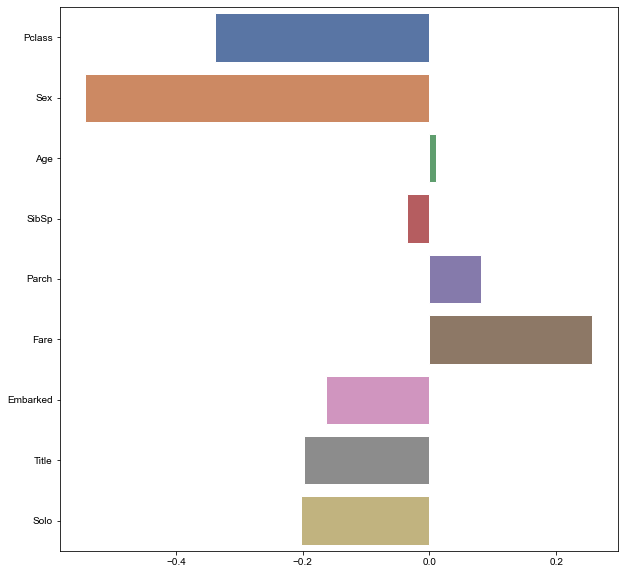

In [52]:
fig, axs = plt.subplots(figsize=(10,10)) 
sns.set(font_scale=3)
sns.barplot(x=train_data.corr()['Survived'][1:].values,
            y=train_data.columns[1:],
            ax = axs)

# Simple Model


In [53]:
from sklearn.model_selection import train_test_split
X_train0, X_train1, y_train0, y_train1 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [104]:
df_score = []

AttributeError: 'str' object has no attribute 'append'

In [116]:
from sklearn.metrics import f1_score
df_score = []

from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(max_iter=1000)
LRmodel.fit(X_train0,y_train0)
df_score.append('LRmodel')
df_score.append([LRmodel.score(X_train0,y_train0),
                 LRmodel.score(X_train1,y_train1), 
                 f1_score(LRmodel.predict(X_train0),y_train0),
                 f1_score(LRmodel.predict(X_train1),y_train1)])

from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(n_estimators=100)
RFmodel.fit(X_train0,y_train0)
df_score[0] += ' RFmodel'
df_score.append([RFmodel.score(X_train0,y_train0),
                 RFmodel.score(X_train1,y_train1), 
                 f1_score(RFmodel.predict(X_train0),y_train0),
                 f1_score(RFmodel.predict(X_train1),y_train1)])

from sklearn.naive_bayes import GaussianNB
GNBmodel = GaussianNB()
df_score[0] += ' GNBmodel'
GNBmodel.fit(X_train0,y_train0)
df_score.append([GNBmodel.score(X_train0,y_train0),
                 GNBmodel.score(X_train1,y_train1), 
                 f1_score(GNBmodel.predict(X_train0),y_train0),
                 f1_score(GNBmodel.predict(X_train1),y_train1)])


from sklearn.tree import DecisionTreeClassifier
DTmodel = DecisionTreeClassifier(max_depth=20,max_leaf_nodes=5)
df_score[0] += ' DTmodel'
DTmodel.fit(X_train0,y_train0)
df_score.append([DTmodel.score(X_train0,y_train0),
                 DTmodel.score(X_train1,y_train1), 
                 f1_score(DTmodel.predict(X_train0),y_train0),
                 f1_score(DTmodel.predict(X_train1),y_train1)])

from sklearn.ensemble import GradientBoostingClassifier
XGBmodel = GradientBoostingClassifier()
df_score[0] += ' XGBmodel'
XGBmodel.fit(X_train0,y_train0)
df_score.append([XGBmodel.score(X_train0,y_train0),
                 XGBmodel.score(X_train1,y_train1), 
                 f1_score(XGBmodel.predict(X_train0),y_train0),
                 f1_score(XGBmodel.predict(X_train1),y_train1)])

from sklearn.ensemble import VotingClassifier
er = VotingClassifier([('LR', LRmodel),
                    ('RF', RFmodel),
                    ('GNB', GNBmodel),
                    ('DT', DTmodel),
                    ('XGB', XGBmodel)],voting='soft')
df_score[0] += ' er'
er.fit(X_train0,y_train0)
df_score.append([er.score(X_train0,y_train0),
                 er.score(X_train1,y_train1), 
                 f1_score(er.predict(X_train0),y_train0),
                 f1_score(er.predict(X_train1),y_train1)])
index_val = df_score[0].split(' ')
df_score = pd.DataFrame(df_score[1:],columns=['Train Accuracy','Test Accuracy','F1 score train','F1 score test'],index=index_val)
df_score

,Train Accuracy,Test Accuracy,F1 score train,F1 score test
LRmodel,0.794944,0.782123,0.722433,0.715328
RFmodel,0.984551,0.832402,0.979592,0.765625
GNBmodel,0.796348,0.787709,0.730983,0.736111
DTmodel,0.811798,0.782123,0.754579,0.731034
XGBmodel,0.897472,0.837989,0.857700,0.771654
er,0.856742,0.793296,0.803089,0.725926


In [95]:
id_data = data_df[data_df['Survived'].isnull()].index.values
pred_data = XGBmodel.predict(X_test)
#pred_data = ((model(X_test_torch)>=0.5)*1).detach().numpy().flatten()
out_data = {'PassengerId':id_data+1,'Survived':pred_data.astype(int)}
df = pd.DataFrame(out_data)
df.to_csv('output.csv', index = False)

# Neural Network

In [176]:
import torch
from torch import nn

class LogisticNN(nn.Module):
    def __init__(self):
        super(LogisticNN, self).__init__()
        layer1_out = 8
        layer2_out = 8
        self.layer1 = nn.Linear(8,layer1_out,bias=True)
        self.layer2 = nn.Linear(layer1_out,layer2_out,bias=True)
        self.output = nn.Linear(layer2_out,1,bias=True)

    def forward(self, x):
        z = torch.relu(self.layer1(x))
        z = torch.relu(self.layer2(z))
        z = torch.sigmoid(self.output(z))
        return z
X_train_torch = torch.Tensor(X_train.to_numpy().astype(np.float32))
y_train_torch = torch.Tensor(y_train.to_numpy().astype(np.float32)).view(-1,1)
X_test_torch = torch.Tensor(X_test.to_numpy().astype(np.float32))
model = LogisticNN()
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [178]:
for i in range(10000):
    z = model(X_train_torch)
    J = loss(z,y_train_torch)
    
    J.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i%1000==0:
        with torch.no_grad():
            print(i,J,((z>0.5)*1==y_train_torch).sum()/y_train_torch.shape[0])

0 tensor(0.3372, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8563)
1000 tensor(0.3296, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8642)
2000 tensor(0.3272, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8664)
3000 tensor(0.3256, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8664)
4000 tensor(0.3215, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8721)
5000 tensor(0.3174, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8709)
6000 tensor(0.3160, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8698)
7000 tensor(0.3154, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8721)
8000 tensor(0.3151, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8709)
9000 tensor(0.3147, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8721)


In [186]:

for i in range(10):
    print(i,((z>=i/10)*1==y_train_torch).sum()/y_train_torch.shape[0])


0 tensor(0.3838)
1 tensor(0.7127)
2 tensor(0.7991)
3 tensor(0.8530)
4 tensor(0.8698)
5 tensor(0.8709)
6 tensor(0.8664)
7 tensor(0.8620)
8 tensor(0.8485)
9 tensor(0.7980)


Voting Classifier = 77.9% acc

Decision Tree 74.6% acc

Random forest = 75%

NN fast = 


In [216]:
id_data = data_df[data_df['Survived'].isnull()].index.values
pred_data = eclf1.predict(X_test)
#pred_data = ((model(X_test_torch)>=0.5)*1).detach().numpy().flatten()
out_data = {'PassengerId':id_data+1,'Survived':pred_data.astype(int)}
df = pd.DataFrame(out_data)
df.to_csv('output.csv', index = False)